# Objective : Some unsupervised learning

In [30]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polynomial_featextract import poly_featextract

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import raw data and params.txt file

datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"
raw_data = load_data(path=datadir_path,as_df=False)
params_data = load_params(path=datadir_path)
# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading data into numpy array. Took 19.71s
Finsihed loading parameters file


In [ ]:
print(raw_data.shape)
offset = 150
shifted_data, center = get_window(raw_data,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

(10500, 942)
The Echo pulse occurs at timestep: 628


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
from sklearn.preprocessing import ( PowerTransformer, QuantileTransformer,
StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer )

In [ ]:
 y = params_data['stencil_type'].values
 pt = PowerTransformer(method='box-cox')
 qt = QuantileTransformer(output_distribution='normal')

In [ ]:
pt_data = pt.fit_transform(rscl_data)
qt_data = qt.fit_transform(rscl_data)

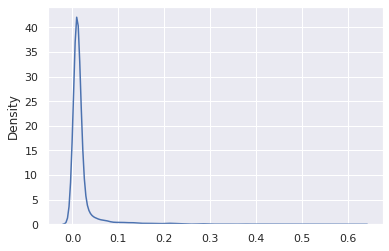

In [ ]:
sns.kdeplot(rscl_data[:,0])

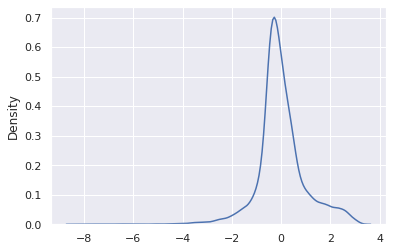

In [ ]:
sns.kdeplot(pt_data[:,0])

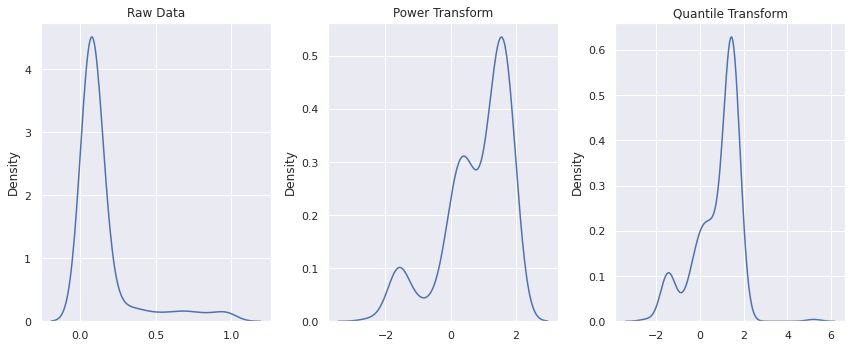

In [ ]:
fig,axes = plt.subplots(1,3, figsize=(12,5))
titles = ['Raw Data', 'Power Transform','Quantile Transform']
sns.kdeplot(rscl_data[150,:],ax=axes[0])
sns.kdeplot(pt_data[150,:],ax=axes[1])
sns.kdeplot(qt_data[150,:],ax=axes[2])

for counter, ax in enumerate(axes):
    ax.set_title(titles[counter])

plt.tight_layout()
plt.show()

# PCA 2D

In [ ]:
pt_pca2d, ptpca2d_var = pca2D(pt_data)
qt_pca2d, qtpca2d_var = pca2D(qt_data)

In [ ]:
print("power transform",ptpca2d_var)
print("quantile transform",qtpca2d_var)

power transform [0.43488138 0.19390574]
quantile transform [0.4279739  0.18449325]


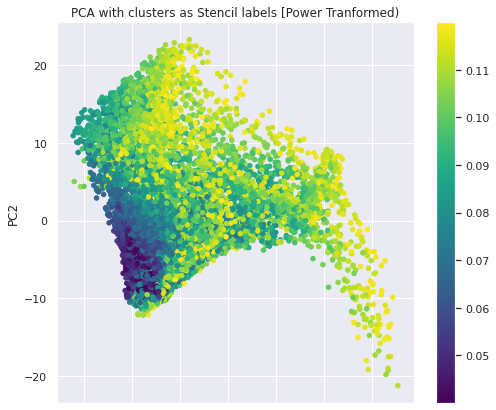

In [33]:
pt_pca2d.plot.scatter("PC1","PC2",c=wlist_file,cmap='viridis',figsize=(8,7),title="PCA with clusters as Stencil labels [Power Tranformed)")
plt.show()

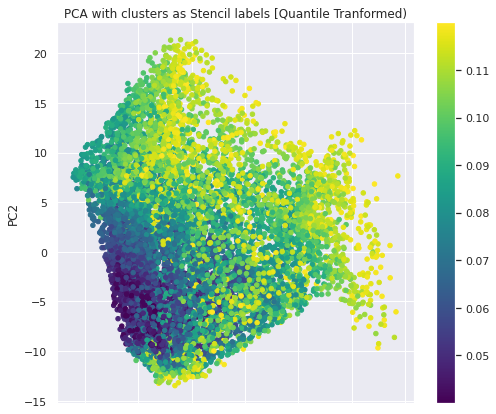

In [34]:
qt_pca2d.plot.scatter("PC1","PC2",c=wlist_file,cmap='viridis',figsize=(8,7))
plt.title("PCA with clusters as Stencil labels [Quantile Tranformed)")
plt.xlabel("PC1")
plt.show()

In [31]:
# Plot kernel-integral
datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"
wlist = "w_list.txt"

wlist_file = np.loadtxt(os.path.join(datadir_path,wlist))
wlist_file



array([0.05293969, 0.04849052, 0.06326192, ..., 0.10678829, 0.08400416,
       0.04130729])

# PCA 3D

In [ ]:
pt_pca3d, ptpca3d_var = pca3D(pt_data)
qt_pca3d, qtpca3d_var = pca3D(qt_data)

In [ ]:
pt_pca3d

,PC1,PC2,PC3
0,-4.571766,-8.729411,8.455580
1,-4.407146,-9.057352,7.716754
2,-10.239639,-7.650876,0.641794
3,36.283941,-13.114558,16.742890
4,-4.142050,-9.819144,6.027787
...,...,...,...
10495,-7.615628,-4.906399,1.578540
10496,-10.607745,-3.074127,5.470552
10497,-5.993263,-11.002847,6.108999
10498,-5.721635,-9.812157,-0.166099


# Clustering

In [39]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#### PT data

In [ ]:
kmeans = KMeans(n_clusters=3,init="k-means++")
kmeans.fit(pt_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
pca2d_3clusters,pca2d_var = pca2D(pt_data)
print("Variance cpatured by PCApca2d_3clusters,pca2d_var = pca2D(pt_data)
print("Variance cpatured by PCA axes:",pca2d_var) axes:",pca2d_var)

Variance cpatured by PCA axes: [0.43488138 0.19390574]


In [ ]:
pca2d_3clusters['cluster'] = kmeans.labels_ +1
npoints = 5000

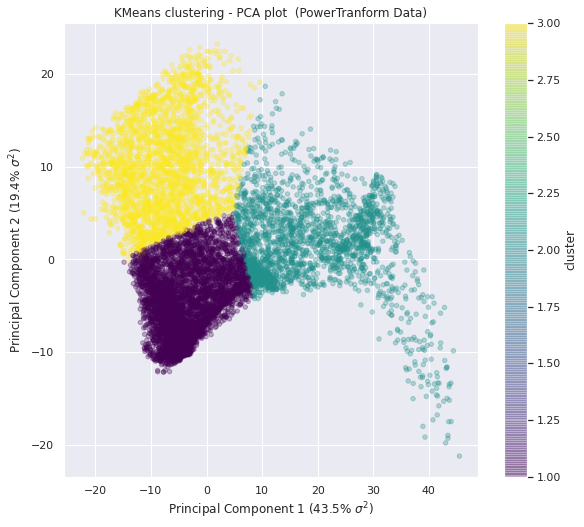

In [ ]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
pca2d_3clusters.plot.scatter(x='PC1',y='PC2',c='cluster',
                        cmap='viridis',alpha=0.3,ax=ax)
ax.set(xlabel=f"Principal Component 1 ({pca2d_var[0]*100:.3}% $\sigma ^2$)",
       ylabel=f"Principal Component 2 ({pca2d_var[1]*100:.3}% $\sigma ^2$)",
       title="KMeans clustering - PCA plot  (PowerTranform Data)")
plt.show()

### QT Data

In [40]:
kmeans = KMeans(n_clusters=3,init="k-means++")
kmeans.fit(qt_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [41]:
pca2d_3clusters,pca2d_var = pca2D(qt_data)
print("Variance cpatured by PCA axes:",pca2d_var)

Variance cpatured by PCA axes: [0.4279739  0.18449325]


In [42]:
pca2d_3clusters['cluster'] = kmeans.labels_ +1
npoints = 5000

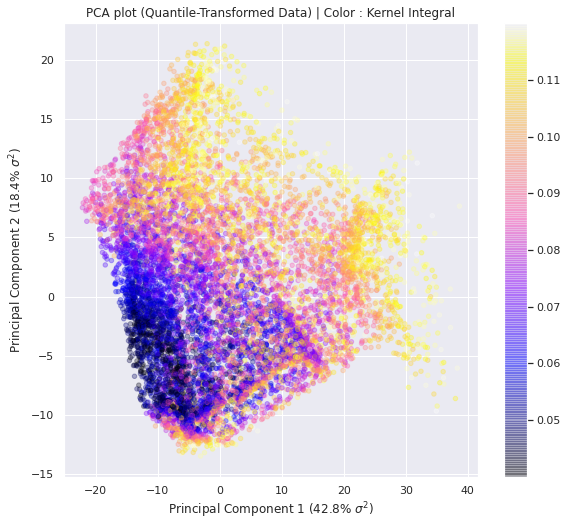

In [54]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
pca2d_3clusters.plot.scatter(x='PC1',y='PC2',c=wlist_file,
                        cmap='gnuplot2',alpha=0.3,ax=ax)
ax.set(xlabel=f"Principal Component 1 ({pca2d_var[0]*100:.3}% $\sigma ^2$)",
       ylabel=f"Principal Component 2 ({pca2d_var[1]*100:.3}% $\sigma ^2$)",
       title="PCA plot (Quantile-Transformed Data) | Color : Kernel Integral")
plt.show()

# Polynomial features

In [ ]:
pfeatures = poly_featextract(rscl_data, n_splits=[2,4,5,10],order_fits=[3,3,3,3], as_df=True)

In [ ]:
pfeatures.head()

,2_1_0,2_1_1,2_1_2,2_1_3,2_2_0,2_2_1,2_2_2,2_2_3,4_1_0,4_1_1,4_1_2,4_1_3,4_2_0,4_2_1,4_2_2,4_2_3,4_3_0,4_3_1,4_3_2,4_3_3,4_4_0,4_4_1,4_4_2,4_4_3,5_1_0,5_1_1,5_1_2,5_1_3,5_2_0,5_2_1,5_2_2,5_2_3,5_3_0,5_3_1,5_3_2,5_3_3,5_4_0,5_4_1,5_4_2,5_4_3,...,10_1_0,10_1_1,10_1_2,10_1_3,10_2_0,10_2_1,10_2_2,10_2_3,10_3_0,10_3_1,10_3_2,10_3_3,10_4_0,10_4_1,10_4_2,10_4_3,10_5_0,10_5_1,10_5_2,10_5_3,10_6_0,10_6_1,10_6_2,10_6_3,10_7_0,10_7_1,10_7_2,10_7_3,10_8_0,10_8_1,10_8_2,10_8_3,10_9_0,10_9_1,10_9_2,10_9_3,10_10_0,10_10_1,10_10_2,10_10_3
0,0.000001,0.000078,0.000389,-0.000389,-1.170266e-06,0.000078,-0.000084,-0.005874,2.236470e-07,0.000006,0.000135,0.011056,0.000004,0.000259,0.007989,0.151059,-0.000004,0.000274,-0.008279,0.146295,-2.149142e-07,6.155184e-06,-0.000127,0.010173,4.935042e-08,-9.564643e-07,0.000146,0.010836,0.000001,0.000088,0.002330,0.050902,-1.240648e-06,-0.000796,0.000025,0.788313,-0.000002,0.000088,-0.002004,0.043527,...,-0.000004,3.937068e-07,0.000778,0.007660,2.546437e-08,0.000025,0.000113,0.011351,0.000003,0.000015,0.000244,0.031908,0.000005,0.000144,0.005397,0.110987,0.000009,0.000671,0.025493,0.506981,4.404496e-08,0.000656,-0.026719,0.493492,-0.000005,0.000145,-0.005154,0.099619,-3.561492e-06,0.000002,-0.000040,0.029204,0.000001,0.000023,-0.000220,0.010351,0.000003,-4.742971e-07,-0.000630,0.007237
1,0.000001,0.000078,0.000448,0.001242,-1.187043e-06,0.000078,0.000027,-0.008931,2.215008e-07,0.000007,0.000148,0.011400,0.000004,0.000257,0.008087,0.155030,-0.000004,0.000277,-0.008140,0.139200,-2.150578e-07,5.847759e-06,-0.000100,0.009622,5.348174e-08,-7.629906e-07,0.000151,0.011101,0.000001,0.000088,0.002405,0.052983,-8.409482e-07,-0.000797,-0.000491,0.787621,-0.000002,0.000088,-0.001867,0.039771,...,-0.000004,3.085515e-06,0.000780,0.007683,6.577907e-08,0.000028,0.000119,0.011560,0.000003,0.000017,0.000310,0.033036,0.000005,0.000144,0.005447,0.114158,0.000009,0.000658,0.025438,0.512003,-4.031941e-07,0.000675,-0.026876,0.485822,-0.000005,0.000146,-0.005067,0.093880,-3.919389e-06,-0.000003,0.000076,0.027217,0.000001,0.000016,-0.000196,0.010274,0.000003,-7.368338e-06,-0.000562,0.007548
2,0.000001,0.000078,0.000309,0.002121,-1.406986e-06,0.000078,0.001366,-0.040420,3.011159e-07,0.000003,0.000062,0.015478,0.000004,0.000259,0.007630,0.150626,-0.000006,0.000335,-0.006469,0.054775,1.576197e-07,-4.457967e-07,-0.000172,0.005378,1.130315e-07,-6.060068e-06,0.000133,0.015633,0.000001,0.000084,0.002449,0.053891,6.345070e-07,-0.000842,-0.003147,0.763734,-0.000003,0.000060,0.000137,0.004831,...,-0.000005,-7.924675e-06,0.001086,0.011249,5.534691e-07,0.000026,-0.000077,0.014808,0.000004,0.000024,0.000249,0.032969,0.000005,0.000132,0.005112,0.113869,0.000010,0.000707,0.025671,0.501332,-2.417505e-06,0.000851,-0.029530,0.405186,-0.000002,0.000219,-0.003503,0.021530,5.906802e-07,0.000006,-0.000393,0.007274,0.000003,-0.000022,-0.000514,0.008249,0.000002,-2.192775e-07,-0.000209,0.003928
3,0.000003,0.000026,-0.008515,0.398645,4.961528e-07,0.000024,-0.004569,0.453401,3.582810e-06,-0.000153,0.003142,0.558517,-0.000004,0.000325,0.012640,0.249613,-0.000021,-0.000052,0.015769,0.671904,-1.123982e-05,-7.467074e-05,0.011848,0.386328,1.741358e-05,-2.428894e-04,-0.003017,0.518130,0.000002,0.000552,-0.010246,0.174025,5.025033e-06,-0.000381,-0.002618,0.771057,0.000023,-0.000455,-0.021611,0.691974,...,-0.000018,-1.136943e-04,0.019888,0.354187,6.979802e-05,0.002911,-0.011550,0.323371,-0.000007,0.000789,-0.020678,0.440769,-0.000007,0.000016,0.012085,0.181037,-0.000208,0.000602,0.045921,0.610748,-9.352133e-05,0.001560,0.001255,0.527728,-0.000060,-0.001001,0.023720,0.813619,-1.219899e-04,0.000352,0.002809,0.339447,0.000053,-0.000710,-0.002286,0.344669,-0.000009,-9.708226e-04,-0.012851,0.510316
4,0.000001,0.000078,0.000552,0.005029,-1.220619e-06,0.000078,0.000267,-0.016190,1.944124e-07,0.000007,0.000210,0.012615,0.000004,0.000254,0.008289,0.162810,-0.000004,0.000285,-0.007789,0.123668,-2.987454e-07,4.270846e-06,0.000077,0.008701,2.661306e-08,1.556227e-07,0.000202,0.01

In [ ]:
random_state = 42
figsize=(10,7)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
?DecisionTreeClassifier

In [ ]:
std_clf = make_pipeline(PowerTransformer(),
                        #QuantileTransformer(output_distribution='normal'),
                        #PowerTransformer(),
                        RandomForestClassifier(n_estimators=100, n_jobs=-1))
                       #DecisionTreeClassifier())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pfeatures,
                                                    params_data['stencil_type'].values, 
                                                    test_size=0.30, random_state=42)

In [ ]:
std_clf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('powertransformer',
                 PowerTransformer(copy=True, method='yeo-johnson',
                                  standardize=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=-1,
                                        oob_score=False, random_state=None,
                                        verbo

In [ ]:
pred_test_std= std_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, pred_test_std)

0.9831746031746031

In [ ]:
std_clf.classes_

array([0., 1., 2.])